In [1]:
!pip install modal-python

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score

from modAL.models import ActiveLearner,Committee
from modAL.uncertainty import uncertainty_sampling, entropy_sampling,margin_sampling

from keras.datasets import imdb

In [3]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=10000)

In [4]:
word_index = imdb.get_word_index()
index_word = {value: key for (key, value) in word_index.items()}

In [5]:
def decode_review(review):
    return " ".join([index_word.get(i - 3, "?") for i in review])

In [6]:
X_train_text = [decode_review(review) for review in X_train]
X_test_text = [decode_review(review) for review in X_test]

In [7]:
vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf = vectorizer.transform(X_test_text)

In [8]:
initial_idx = np.random.choice(range(X_train_tfidf.shape[0]), size=100, replace=False)
X_initial, y_initial = X_train_tfidf[initial_idx], y_train[initial_idx]

In [9]:
X_pool = np.delete(X_train_tfidf.toarray(), initial_idx, axis=0)
y_pool = np.delete(y_train, initial_idx, axis=0)

In [10]:
def random_sampling(learner, X_pool, n_samples=1):
    ''' Randomly selects n_samples from X_pool '''
    n_pool = len(X_pool)
    query_idx = np.random.choice(range(n_pool), size=n_samples, replace=False)
    return query_idx, X_pool[query_idx]

In [11]:
learner_random = ActiveLearner(
    estimator=SVC(probability=True),
    query_strategy=random_sampling,
    X_training=X_initial, y_training=y_initial
)

In [12]:
# Naive Bayes with Uncertainty Sampling
learner_uncertainty = ActiveLearner(
    estimator=SVC(probability=True),
    query_strategy=uncertainty_sampling,
    X_training=X_initial,
    y_training=y_initial,
)

In [13]:
# Naive Bayes with Entropy Sampling
learner_entropy = ActiveLearner(
    estimator=SVC(probability=True),
    query_strategy=entropy_sampling,
    X_training=X_initial,
    y_training=y_initial,
)

In [14]:
# Naive Bayes with Margin Sampling
learner_margin = ActiveLearner(
    estimator=SVC(probability=True),
    query_strategy=margin_sampling,
    X_training=X_initial,
    y_training=y_initial,
)

In [15]:
n_queries = 50
performance_random = []
performance_uncertainty = []
performance_entropy = []
performance_margin = []

In [16]:
def run_active_learning(learner, X_pool, y_pool, strategy_name):
    """Keeps the loop running and capture the performance of the model"""
    performance = []
    for i in range(n_queries):
        query_idx, _ = learner.query(X_pool)
        learner.teach(X_pool[query_idx], y_pool[query_idx])
        X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(
            y_pool, query_idx, axis=0
        )
        y_pred = learner.predict(X_test_tfidf)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        performance.append((acc, f1))
        print(
            f"{strategy_name} | Query {i+1}: Accuracy = {acc:.4f}, F1-Score = {f1:.4f}"
        )
    return performance

In [17]:
for strategy, learner in zip(
    ["Random Sampling","Uncertainty Sampling", "Entropy Sampling", "Margin Sampling"],
    [learner_random, learner_uncertainty, learner_entropy, learner_margin],
):
    # Reset the pools for each learner
    X_pool = np.delete(X_train_tfidf.toarray(), initial_idx, axis=0)
    y_pool = np.delete(y_train, initial_idx, axis=0)

    # Run active learning
    performance = run_active_learning(learner, X_pool.copy(), y_pool.copy(), strategy)

    if strategy == "Random Sampling":
        performance_random = performance
    elif strategy == "Uncertainty Sampling":
        performance_uncertainty = performance
    elif strategy == "Entropy Sampling":
        performance_entropy = performance
    elif strategy == "Margin Sampling":
        performance_margin = performance

Random Sampling | Query 1: Accuracy = 0.5942, F1-Score = 0.7038
Random Sampling | Query 2: Accuracy = 0.6202, F1-Score = 0.7122
Random Sampling | Query 3: Accuracy = 0.5955, F1-Score = 0.7043
Random Sampling | Query 4: Accuracy = 0.6188, F1-Score = 0.7112
Random Sampling | Query 5: Accuracy = 0.6574, F1-Score = 0.7201
Random Sampling | Query 6: Accuracy = 0.6189, F1-Score = 0.7129
Random Sampling | Query 7: Accuracy = 0.6598, F1-Score = 0.7227
Random Sampling | Query 8: Accuracy = 0.6228, F1-Score = 0.7130
Random Sampling | Query 9: Accuracy = 0.6590, F1-Score = 0.7221
Random Sampling | Query 10: Accuracy = 0.6248, F1-Score = 0.7145
Random Sampling | Query 11: Accuracy = 0.5966, F1-Score = 0.7049
Random Sampling | Query 12: Accuracy = 0.5775, F1-Score = 0.6984
Random Sampling | Query 13: Accuracy = 0.5948, F1-Score = 0.7046
Random Sampling | Query 14: Accuracy = 0.6212, F1-Score = 0.7146
Random Sampling | Query 15: Accuracy = 0.6610, F1-Score = 0.7250
Random Sampling | Query 16: Accura

In [18]:
acc_random, f1_random = zip(*performance_random)
acc_uncertainty, f1_uncertainty = zip(*performance_uncertainty)
acc_entropy, f1_entropy = zip(*performance_entropy)
acc_margin, f1_margin = zip(*performance_margin)

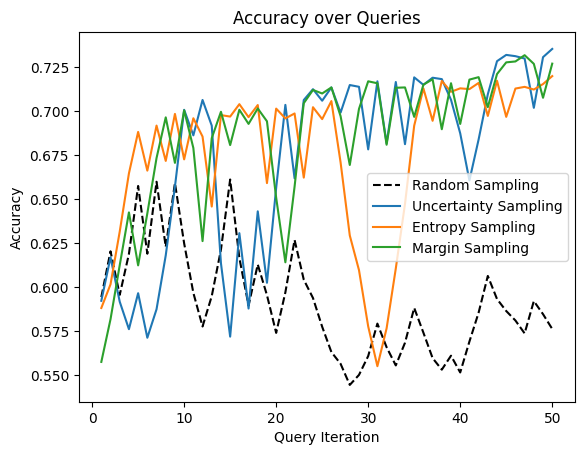

In [22]:
plt.plot(range(1, n_queries + 1), acc_random, label="Random Sampling", color='black', linestyle='--')
plt.plot(range(1, n_queries + 1), acc_uncertainty, label="Uncertainty Sampling")
plt.plot(range(1, n_queries + 1), acc_entropy, label="Entropy Sampling")
plt.plot(range(1, n_queries + 1), acc_margin, label="Margin Sampling")
plt.title("Accuracy over Queries")
plt.xlabel("Query Iteration")
plt.ylabel("Accuracy")
plt.grid(False)
plt.legend()

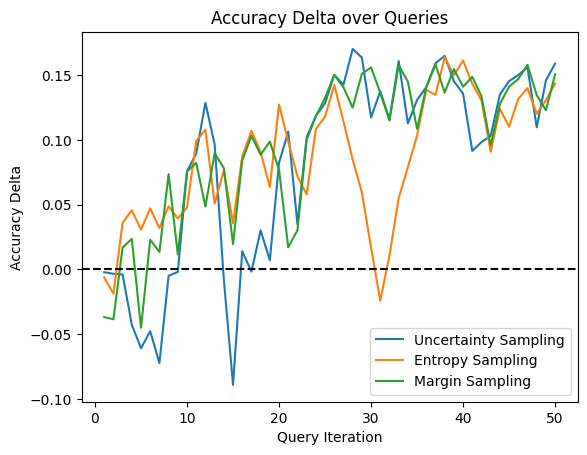

In [23]:
plt.plot(range(1, n_queries + 1), np.array(acc_uncertainty) - np.array(acc_random), label="Uncertainty Sampling")
plt.plot(range(1, n_queries + 1), np.array(acc_entropy) - np.array(acc_random), label="Entropy Sampling")
plt.plot(range(1, n_queries + 1), np.array(acc_margin) - np.array(acc_random), label="Margin Sampling")
plt.title("Accuracy Delta over Queries")
plt.xlabel("Query Iteration")
plt.ylabel("Accuracy Delta")
plt.axhline(y=0, color='black', linestyle='--')
plt.grid(False)
plt.legend()

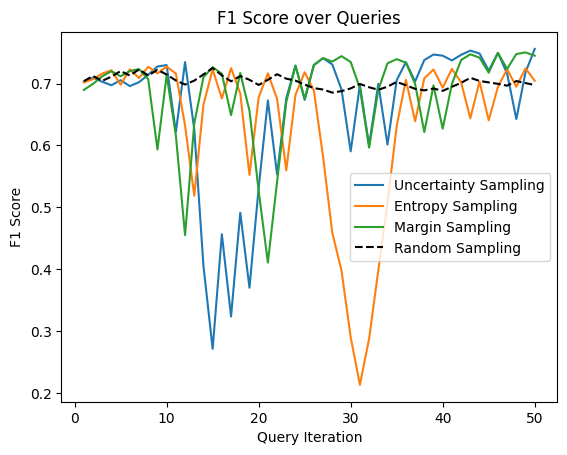

In [24]:
plt.plot(range(1, n_queries + 1), f1_uncertainty, label="Uncertainty Sampling")
plt.plot(range(1, n_queries + 1), f1_entropy, label="Entropy Sampling")
plt.plot(range(1, n_queries + 1), f1_margin, label="Margin Sampling")
plt.plot(range(1, n_queries + 1), f1_random, label="Random Sampling", color='black', linestyle='--')
plt.title("F1 Score over Queries")
plt.xlabel("Query Iteration")
plt.ylabel("F1 Score")
plt.grid(False)
plt.legend()

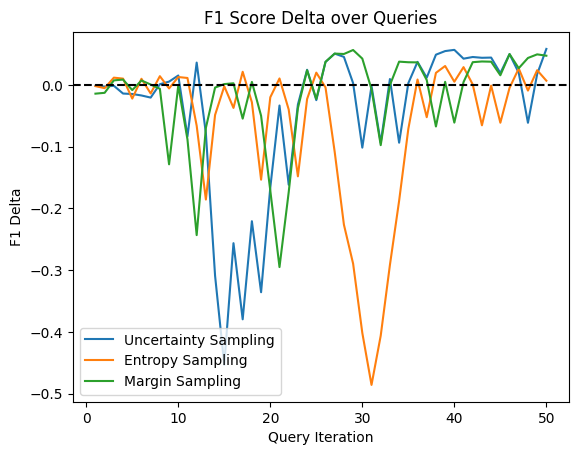

In [25]:
plt.plot(range(1, n_queries + 1), np.array(f1_uncertainty) - np.array(f1_random), label="Uncertainty Sampling")
plt.plot(range(1, n_queries + 1), np.array(f1_entropy) - np.array(f1_random), label="Entropy Sampling")
plt.plot(range(1, n_queries + 1), np.array(f1_margin) - np.array(f1_random), label="Margin Sampling")
plt.title("F1 Score Delta over Queries")
plt.xlabel("Query Iteration")
plt.ylabel("F1 Delta")
plt.axhline(y=0, color='black', linestyle='--')
plt.grid(False)
plt.legend()